<a href="https://colab.research.google.com/github/lindsey-chang/BERT-Chinese-Muti-Class-Classification/blob/main/Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FineTuning BERT for Multi-Class Classification with **Vehicle Command** datasets


In [ ]:
#  restart colab environment
# import os
# os.kill(os.getpid(), 9)

In [ ]:
#!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00


In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df_org= pd.read_csv("/content/drive/MyDrive/998/MDT-dataset.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,category,text
361,打开部分遮阳帘,给我把[PERCENT]遮阳帘启动
73,打开低速警示音,开开低速提醒音
374,打开部分遮阳帘,开[PERCENT]汽车遮阳帘
155,打开车身稳定系统（esp）,给我用一下车身电子稳定系统
104,打开低速警示音,启动一下低速警示音


In [ ]:
# 删除某些category它对应的text过少的行
df_org = df_org[~df_org['category'].isin(['帮我下单换电申请换电', '打开倒车侧向辅助'])]

# 显示处理后的前几行数据
df_org.head()


,category,text
361,打开部分遮阳帘,给我把[PERCENT]遮阳帘启动
73,打开低速警示音,开开低速提醒音
374,打开部分遮阳帘,开[PERCENT]汽车遮阳帘
155,打开车身稳定系统（esp）,给我用一下车身电子稳定系统
104,打开低速警示音,启动一下低速警示音


In [ ]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['打开部分遮阳帘',
 '打开低速警示音',
 '打开车身稳定系统（esp）',
 '打开大灯延时熄灭',
 '打开WIFI',
 '打开发动机自动启停',
 '打开顶棚灯',
 '打开车道保持辅助']


## 为什么需要 id2label 和 labe2ids？

在 NLP 任务中，尤其是涉及分类问题的任务中，id2label 和 label2id 字典用于将类标签（类别）映射到整数 ID，反之亦然。这些映射对于 NLP 管道的各个阶段（如数据预处理、模型训练和评估）都至关重要。

数据预处理： 为了将文本数据输入 NLP 模型，首先必须对文本进行标记化，然后将其转换为数值。同样，类标签也必须转换成数值表示。label2id 词典有助于将原始类标签转换为整数 ID。

模型训练： NLP 模型通常输出类的概率分布作为预测值。在训练过程中，模型的预测会与真实标签（已转换为整数 ID）进行比较，以计算损失并优化模型参数。

模型评估和解释： 模型训练完成后，需要将其预测结果（以整数 ID 的形式）映射回原始类标签，以便对结果进行解释。id2label 词典用于进行这种转换。
对于 `BertForSequenceClassification` 模型，我也需要以字典形式精确映射 id2labels 和 labels2id。

### 因此，在开始训练模型之前，需要使用 id2label 和 label2id 创建预期 id 与其标签的映射：





In [ ]:
for key, value in enumerate(labels):
    print(value)

打开部分遮阳帘
打开低速警示音
打开车身稳定系统（esp）
打开大灯延时熄灭
打开WIFI
打开发动机自动启停
打开顶棚灯
打开车道保持辅助


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'打开部分遮阳帘': 0,
 '打开低速警示音': 1,
 '打开车身稳定系统（esp）': 2,
 '打开大灯延时熄灭': 3,
 '打开WIFI': 4,
 '打开发动机自动启停': 5,
 '打开顶棚灯': 6,
 '打开车道保持辅助': 7}

In [ ]:
id2label

{0: '打开部分遮阳帘',
 1: '打开低速警示音',
 2: '打开车身稳定系统（esp）',
 3: '打开大灯延时熄灭',
 4: '打开WIFI',
 5: '打开发动机自动启停',
 6: '打开顶棚灯',
 7: '打开车道保持辅助'}

In [ ]:
df_org.head()

,category,text
361,打开部分遮阳帘,给我把[PERCENT]遮阳帘启动
73,打开低速警示音,开开低速提醒音
374,打开部分遮阳帘,开[PERCENT]汽车遮阳帘
155,打开车身稳定系统（esp）,给我用一下车身电子稳定系统
104,打开低速警示音,启动一下低速警示音


### 创建一个新列以数字形式表示类别

I need a 'label' column heading with numeric value else while running the epochs with `trainer.train()` I will get below error

```
BertForSequenceClassification ValueError: 模型未返回

```


### In below I am doing it manually, but I could have also done it with pd.factorize() as below

Pandas factorize 方法用于将分类变量编码为整数。它为给定序列或数据帧中的每个不同类别分配一个唯一的整数值，从而有效地将非数值数据转换为数值数据。

In [ ]:
df_org['labels_num'] = pd.factorize(df_org.category)[0]
df_org.head()

,category,text,labels_num
361,打开部分遮阳帘,给我把[PERCENT]遮阳帘启动,0
73,打开低速警示音,开开低速提醒音,1
374,打开部分遮阳帘,开[PERCENT]汽车遮阳帘,0
155,打开车身稳定系统（esp）,给我用一下车身电子稳定系统,2
104,打开低速警示音,启动一下低速警示音,1


In [ ]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,category,text,labels_num,labels
361,打开部分遮阳帘,给我把[PERCENT]遮阳帘启动,0,0
73,打开低速警示音,开开低速提醒音,1,1
374,打开部分遮阳帘,开[PERCENT]汽车遮阳帘,0,0
155,打开车身稳定系统（esp）,给我用一下车身电子稳定系统,2,2
104,打开低速警示音,启动一下低速警示音,1,1


In [ ]:
#!rm -rf /root/.cache/matplotlib/  # 清除缓存


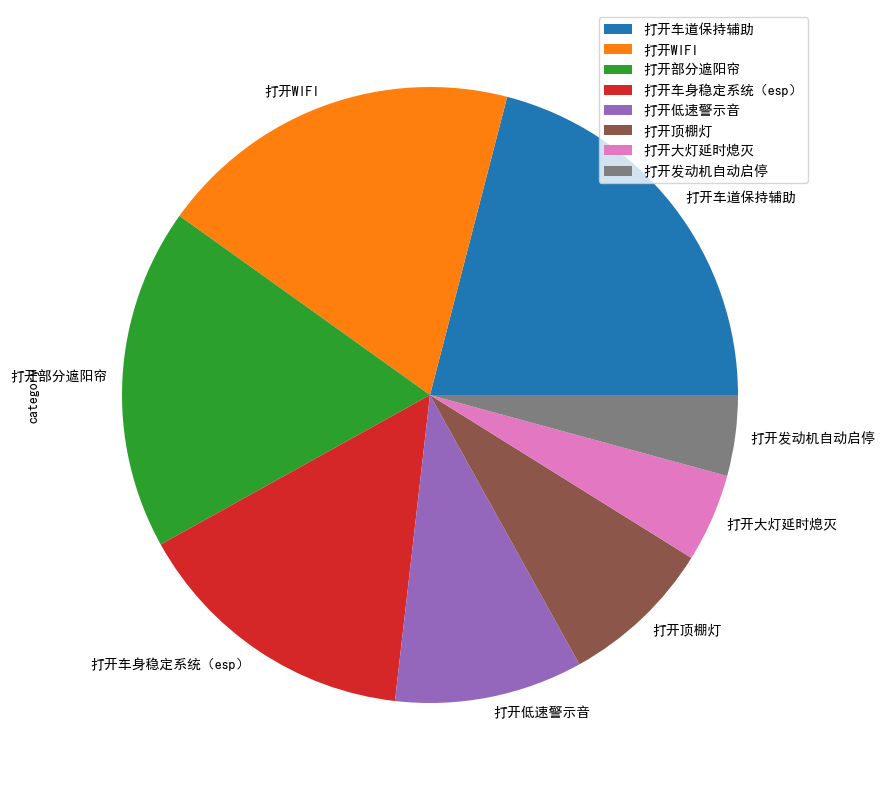

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 加载 SimHei 字体
simhei_font_path = '/content/drive/MyDrive/998/SimHei.ttf'  # 确保这是正确的路径
simhei_font = FontProperties(fname=simhei_font_path)

# 正确显示负号
plt.rcParams['axes.unicode_minus'] = False

# 获取数据
category_counts = df_org.category.value_counts()

# 创建饼图
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(category_counts, labels=category_counts.index, labeldistance=1.05,
       textprops={'fontproperties': simhei_font})

# 设置 ylabel
ax.set_ylabel('category', fontproperties=simhei_font)

# 设置图例
ax.legend(prop=simhei_font)

# 显示图形
plt.show()


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese", max_length=50)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Useful information and understanding you know about the model from the above output

**Model components:** The model consists of several key components, such as:

* Embeddings (word, position, and token type embeddings)

* Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

* Layer normalization and dropout layers for regularization

* GELU activation functions used in the intermediate layers

**Model dimensions:**

* Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

* Position embeddings: The model can handle input sequences of up to 512 tokens in length.

* Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

* Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

--------------------------

## Lets understand the flow of a raw input-text > through the pretrained BERT Model > and finally coming out on the other side of the model as a class prediction in the context of this task-specific fine-tuning.

In BERT-based models like BertForSequenceClassification, the [CLS] token (short for "classification") serves as a special token that is prepended to the input sequence. It is designed to be used as an aggregate representation of the entire input sequence for classification tasks.

Here's a step-by-step breakdown of how the [CLS] token is handled during fine-tuning for a specific classification task:

Tokenization: During the pre-processing of the input text, the tokenizer inserts the [CLS] token at the beginning of the input sequence. For example, if the input text is "This is a sample sentence.", the tokenized input would look like: "[CLS] This is a sample sentence."

**Embeddings:** The tokenized input sequence, including the [CLS] token, is passed through the BERT model's embedding layers, which convert the tokens into continuous-valued word vectors.

**Encoder layers:** The embedded input sequence is then processed through the BERT model's encoder layers, which consist of self-attention mechanisms and feed-forward neural networks. During this process, the model learns to capture the semantic and syntactic information present in the input sequence, as well as any relationships between the tokens.

**Final hidden state of [CLS]:** At the end of the BERT model's encoder layers, each token has a corresponding hidden state vector. For the [CLS] token, its final hidden state is used as an aggregated representation of the entire input sequence. This vector is then passed to the task-specific classification layer.

**Linear layer:** The final hidden state of the [CLS] token is fed into a linear layer, which maps the 768-dimensional vector (assuming the base BERT model) to a vector of size equal to the number of target classes. This is essentially a weight matrix multiplication followed by a bias term addition.

**Softmax function:** The output of the linear layer is then passed through a softmax function, which converts the raw output values into class probabilities. The softmax function ensures that the sum of probabilities across all classes equals 1.

**Prediction:** The class with the highest probability is chosen as the final prediction for the given input sequence.

During task-specific fine-tuning, the model learns to adjust its weights and biases based on the training data and the target labels. This involves updating both the BERT model's pre-trained parameters and the task-specific classification layer's parameters through backpropagation and optimization techniques like gradient descent. This fine-tuning process allows the model to adapt to the specific classification task and improve its performance on the given dataset.

-------------------

## In the above task specific fine tuning do all of the weights of the pretrained BERT model gets modified during this finetuning process or only some of the weights get modified ?


During task-specific fine-tuning, all of the weights of the pre-trained BERT model are potentially subject to modification, including the weights in the embedding layers, the encoder layers, and the classification layer. However, the extent to which each weight is modified depends on the learning rate, the specific task, and the training data.

In general, fine-tuning a pre-trained model like BERT involves updating its weights to better adapt to the target task. When fine-tuning begins, the initial weights of the model come from the pre-trained model, which has already learned general language representations from a large-scale unsupervised task (e.g., masked language modeling).

During fine-tuning, the model is exposed to the particular task-specific training data and labels, and the weights are updated using backpropagation and gradient descent.

Typically, the learning rate for fine-tuning is set to be smaller than the learning rate used during pre-training. This is because the pre-trained model already has a good understanding of language, and the fine-tuning process aims to make small, incremental adjustments to the weights to adapt the model to the specific task without losing the valuable general language knowledge.

## Splitting df_org


In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
df_org.text[:SIZE//2]


361    给我把[PERCENT]遮阳帘启动
73               开开低速提醒音
374      开[PERCENT]汽车遮阳帘
155        给我用一下车身电子稳定系统
104            启动一下低速警示音
             ...        
380     开启[PERCENT]汽车遮阳帘
103            启动我的低速提醒音
81             开启俺的低速提示音
38       启动[position]顶棚灯
314      放下[FRACTION]遮阳帘
Name: text, Length: 248, dtype: object

In [ ]:
df_org.text[SIZE//2:(3*SIZE)//4 ]

167          开车身电子稳定系统
469           给我弄开WIFI
296             启动车道保持
474            给我启动无线网
198           启开车身稳定系统
            ...       
27     开启[position]车顶灯
424         给俺开动车载WIFI
230       给我放开车道保持辅助系统
260      给我用一下车道保持辅助系统
288           开始车道保持辅助
Name: text, Length: 124, dtype: object

In [ ]:
len(train_texts)


248

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(248, 124, 124)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


## From above DataLoader() The line `item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}`

Here I use a dictionary comprehension that constructs a new dictionary called `item`. This line converts the encoding values associated with the input text at the given index idx into PyTorch tensors.

self.encodings is a dictionary containing tokenized input text with keys like 'input_ids', 'token_type_ids', and 'attention_mask'. These keys represent different aspects of the encoded text that are needed for processing by the BERT model. The values associated with these keys are lists or arrays of integers.

.items() is a method that returns a view object displaying a list of a dictionary's key-value pairs as tuples.

The dictionary comprehension iterates through the key-value pairs of self.encodings with the variables key and val. For each key-value pair, it creates a new key-value pair in the item dictionary, where the key remains the same, and the value is a PyTorch tensor created from the elements at index idx of the original value.

In essence, this line of code is converting the relevant parts of the input encodings (e.g., input IDs, attention masks) at the given index idx into PyTorch tensors and storing them in a new dictionary called item. This format is necessary for input to the BERT model during training or evaluation.

Here's an example of the output format for self.encodings:


```
{
    'input_ids': [
        [101, 2023, 2003, 1037, 2742, 102],
        [101, 1045, 2066, 5009, 2102, 102],
        [101, 2129, 2024, 2017, 1029, 102]
    ],
    'token_type_ids': [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ],
    'attention_mask': [
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]
    ]
}
```

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

* input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

* token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

* attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

Note that this example assumes that the maximum sequence length is 6 tokens, and there's no need for padding or truncation. In practice, you would have longer sequences, and padding would be necessary to make all the input sequences have the same length.

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [ ]:
#!pip install accelerate -U



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
#!pip install transformers[torch]

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='"/content/drive/MyDrive/998/TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='/content/drive/MyDrive/998/multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=48, training_loss=1.6444063186645508, metrics={'train_runtime': 9.532, 'train_samples_per_second': 78.053, 'train_steps_per_second': 5.036, 'total_flos': 6117661587456.0, 'train_loss': 1.6444063186645508, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.613342,0.943548,0.955265,0.970833,0.953947
val,0.591441,0.975806,0.981633,0.985577,0.980263
test,0.640302,0.943548,0.954997,0.973485,0.951389


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text
text = "开一下WIFI，谢谢！"

predict(text)

(tensor([[0.0979, 0.1083, 0.1594, 0.0736, 0.4180, 0.0334, 0.0648, 0.0445]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(4, device='cuda:0'),
 '打开WIFI')

## Save model for inference

In [ ]:
model_path = "/content/drive/MyDrive/998/MDT-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/998/MDT-text-classification-model/tokenizer_config.json',
 '/content/drive/MyDrive/998/MDT-text-classification-model/special_tokens_map.json',
 '/content/drive/MyDrive/998/MDT-text-classification-model/vocab.txt',
 '/content/drive/MyDrive/998/MDT-text-classification-model/added_tokens.json',
 '/content/drive/MyDrive/998/MDT-text-classification-model/tokenizer.json')

## Re-Load saved model for inference

In [ ]:
model_path = "MDT-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
nlp("运转车顶灯，好吗？")

# Gives below output
#[{'label': '打开顶棚灯', 'score': 0.3935091495513916}]

[{'label': '打开顶棚灯', 'score': 0.22418943047523499}]

In [ ]:
nlp("小爱同学，给我把遮阳帘打开。")
# Deep Learning and AI is going to change the world

# gives below output
#[{'label': '打开部分遮阳帘', 'score': 0.37722617387771606}]

[{'label': '打开部分遮阳帘', 'score': 0.35661086440086365}]

In [ ]:
nlp("开启顶灯。")


#gives below output
#[{'label': '打开顶棚灯', 'score': 0.2192041128873825}]

[{'label': '打开部分遮阳帘', 'score': 0.2196255922317505}]